In [46]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

def adatron(K,y0, eps=0.0001, t_max=1000):
    '''
    The AdaTron algorithm for SVM learning

    Parameters
    ----------
    K : PxP REAL MATRIX, where P is the training set size
        Contains all pairwise overlaps between training examples: X_ij= x_i*x_j
    y0 : Px1 REAL VECTOR
        All training labels, y_i = label(x_i)
    eps: FLOAT, optional
        Stopping criterion (when update<eps). The default is .0001
    t_max : INT, optional
        max runtime in epochs. The default is 1000.

    Returns
    -------
    hasConverged : BOOLEAN
        whether the algorithm converged (no more updates) or reached t_max and eas stopped.
    A : ExP REAL MATRIX, where E is the number of epochs
        Contains the P-dim support coefficient vectors (alpha) for all the epochs.
        A[t,:] is the support vector alpha_t (at epoch=t)
        When the algorithm has converges, A[-1,:] is the final result that defines the decision rule 

    '''
    P,P1= K.shape
    assert P==P1, "Kernel matrix K should be PxP, where P is the training set size"
    assert y0.size==P, "input-output set size mismatch"
    hasConverged = False
    epochs = 0
    A = []
    eta = 0.2/(np.max(np.linalg.norm(K,axis=0)))
    A.append(np.zeros((P,1)))
    # A.append(np.random.rand(P,1))

    while ((not hasConverged) and (epochs < t_max)):
        a = deepcopy(A[-1])
        for mu in range(P):
            y = y0[mu]
            coeff = y*(a*y0).T
            da = max(-a[mu],eta*(1-coeff@K[:,mu]))
            if np.isinf(da):
                print("stopping because of exploding updates, epoch={}, mu={}".format(epochs,mu))
                hasConverged = True
                continue;
            if np.isnan(da):
                print("nan")
                hasConverged = True
                continue;
            a[mu] += da
        A.append(a)
        diff = abs(A[-1]-A[-2])
        update_flag = np.max(diff) > eps
        hasConverged = hasConverged or (not update_flag)
        epochs += 1

    return hasConverged, np.squeeze(np.array(A))



In [47]:
from scipy.io import loadmat
from sklearn.model_selection import train_test_split


def load_data():
    M = loadmat('data_10D.mat')
    return M['X'], M['w0'], M['y0']


def split_data(X, y, train_samples=5):    
    train_size = train_samples / len(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-train_size)
    return X_train, X_test, y_train, y_test


def get_linear_kernel(X):
    return get_linear_kernel_of_matrices(X, X.T)


def get_linear_kernel_of_matrices(A, B):
    """
    Args:
        A: P1 X N
        B: N X P2
    Returns:
        P1 X P2 matrix
    """
    return np.dot(A, B)
    


(X, w0, y0) = load_data()

In [48]:
import math

def get_adatron_w(alphas, X_train, y_train):
    y_train_v = y_train.flat 
    new_y_train = (alphas * y_train_v)[alphas > 0]
    evaluation_matrix = X_train[alphas > 0] * new_y_train[:, np.newaxis]
    return np.sum(evaluation_matrix, axis=0)


def evaluate_adatron_model(alphas, X_train, y_train, X_test, y_test):
        y_train_v = y_train.flat 
        new_y_train = (alphas * y_train_v)[alphas > 0]
        evaluation_matrix = X_train[alphas > 0] * new_y_train[:, np.newaxis]
        test_predictions = np.sign(np.sum(get_linear_kernel_of_matrices(evaluation_matrix, X_test.T), axis=0))
        
        y_test_v = y_test.flat
        equal_indices = (y_test_v == test_predictions)
        return np.sum(equal_indices)/len(y_test_v)


def perceptron(X: np.ndarray, y0: np.ndarray, eta=0.1  , tmax=math.pow(10,3)):
    N, P = X.shape
    w = np.random.rand(N)
    converged = False

    for epoch in range(int(tmax)):
        dot_product = np.dot(X.T, w)

        y_pred = np.sign(dot_product).flatten()
        y_pred[y_pred == 0] = -1  # Replace 0 with -1 (as wrong prediction)
        misclassified = np.where(y_pred != y0)[0]

        if misclassified.size == 0:
            converged = True
            break

        update = np.sum(X[:, misclassified] * y0[misclassified], axis=1)
        w += eta*update

    return w, converged, epoch + 1
    

def evaluate_perceptron_model(w, X_test, y_test):
        test_predictions = np.sign(np.dot(X_test, w))
        equal_indices = (y_test == test_predictions)
        return np.sum(equal_indices)/len(y_test)


def cosine_distance(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    magnitude1 = np.linalg.norm(vector1)
    magnitude2 = np.linalg.norm(vector2)
    cosine_similarity = dot_product / (magnitude1 * magnitude2)
    cosine_distance = 1 - cosine_similarity
    return cosine_distance

In [40]:
n = 3
P_arr = range(1,201, 10)

average_number_of_support_vectors = np.zeros(len(P_arr))

perceptron_generalization_performance = np.zeros(len(P_arr))
adatron_generalization_performance = np.zeros(len(P_arr))

adatron_average_cosine_distance = np.zeros(len(P_arr))
perceptron_average_cosine_distance = np.zeros(len(P_arr))

for index, P in enumerate(P_arr):
    
    number_of_support_vectors = 0
    adatron_performance = 0
    perceptron_performance = 0
    adatron_cosine_distance = 0
    perceptron_cosine_distance = 0
    
    for i in range(n):
        X_train, X_test, y_train, y_test = split_data(X.T, y0, P)
        
        # adatron
        K = get_linear_kernel(X_train)
        has_converged, A = adatron(K, y_train)
        alphas = A[-1]
        
        number_of_support_vectors += np.sum(A[-1] != 0)
        adatron_w = get_adatron_w(alphas, X_train, y_train)
        adatron_cosine_distance += cosine_distance(w0.flat, adatron_w.flat)
        adatron_performance += evaluate_adatron_model(alphas, X_train, y_train, X_test, y_test)

        # perceptron
        perceptron_w, _, _ = perceptron(X_train.T, y_train.flat)
        perceptron_performance += evaluate_perceptron_model(perceptron_w, X_test, y_test.flat)
        perceptron_cosine_distance += cosine_distance(w0.flat, perceptron_w)
        
    average_number_of_support_vectors[index] = number_of_support_vectors / n
    perceptron_generalization_performance[index] = perceptron_performance / n
    adatron_generalization_performance[index] = adatron_performance / n
    adatron_average_cosine_distance[index] = adatron_cosine_distance / n
    perceptron_average_cosine_distance[index] = perceptron_cosine_distance / n



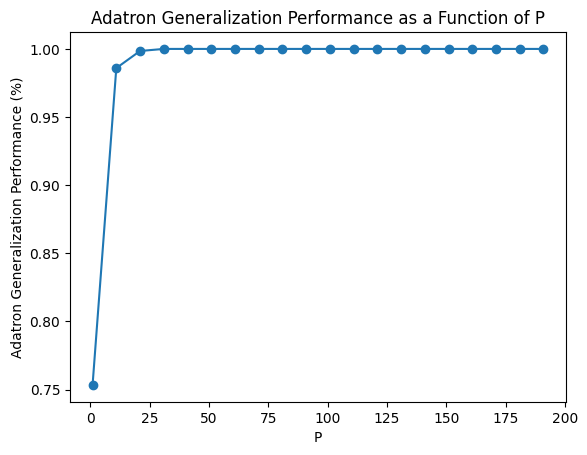

In [41]:
# 1.2.1
# Evaluate and plot the generalization performance (i.e., % correct on the left-out examples) of the optimal solution as a function of P

plt.plot(P_arr, adatron_generalization_performance, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('P')
plt.ylabel('Adatron Generalization Performance (%)')
plt.title('Adatron Generalization Performance as a Function of P')

# Show the plot
plt.show()

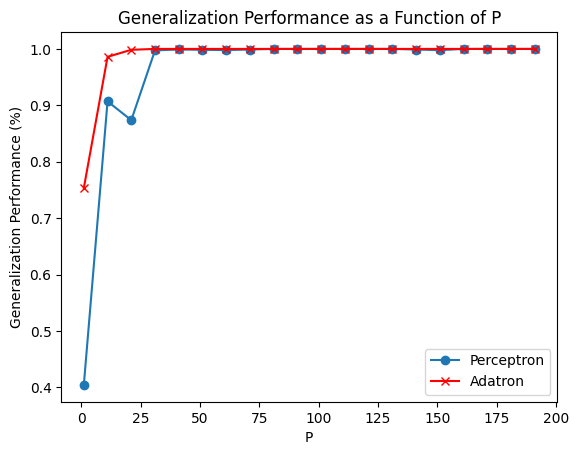

In [42]:
# 1.2.3
# Use the data from data 10D.mat to train and evaluate your implementation of the Perceptron algorithm (problem set
#1, Q.3) for several P values, and produce a plot comparing the generalization performance of the two algorithms.

plt.plot(P_arr, perceptron_generalization_performance, marker='o', linestyle='-', label='Perceptron')
plt.plot(P_arr, adatron_generalization_performance, marker='x', linestyle='-', color='red', label='Adatron')

# Add labels and title
plt.xlabel('P')
plt.ylabel('Generalization Performance (%)')
plt.title('Generalization Performance as a Function of P')
plt.legend()
# Show the plot
plt.show()

In [15]:
perceptron_generalization_performance

array([999.33213213, 997.78786967, 995.36462312])

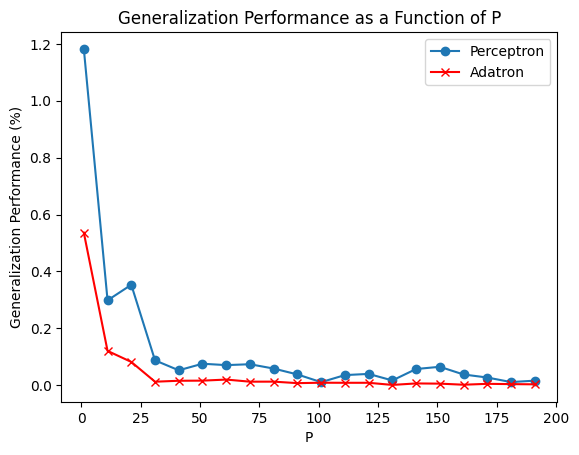

In [43]:
plt.plot(P_arr, perceptron_average_cosine_distance, marker='o', linestyle='-', label='Perceptron')
plt.plot(P_arr, adatron_average_cosine_distance, marker='x', linestyle='-', color='red', label='Adatron')

# Add labels and title
plt.xlabel('P')
plt.ylabel('Generalization Performance (%)')
plt.title('Generalization Performance as a Function of P')
plt.legend()
# Show the plot
plt.show()

In [49]:
import numpy as np
from pylab import scatter

def polynomial_kernel(X1, X2, d=2):
    """
    Compute the polynomial kernel matrix for two sets of samples.

    Parameters:
    - X1: P1 × N matrix (P1 samples, N dimensions)
    - X2: P2 × N matrix (P2 samples, N dimensions)
    - d: Degree of the polynomial kernel

    Returns:
    - K: P1 × P2 kernel matrix
    """
    K = np.dot(X1, X2.T) + 1
    K = np.power(K, d)
    return K


def gaussian_kernel(X, X2, sigma=1.0):
    """
    Compute the Gaussian (RBF) kernel matrix for a set of samples.

    Parameters:
    - X: P × N matrix (P samples, N dimensions)
    - X2: Q × N matrix (Q samples, N dimensions)
    - sigma: Width parameter in the Gaussian kernel

    Returns:
    - K: P × Q kernel matrix
    """
    pairwise_distances_sq = np.square(np.linalg.norm(X[:, np.newaxis] - X2, axis=2))
    K = np.exp(-pairwise_distances_sq / (2 * sigma**2))
    return K


def checkboard(P):
   X=np.random.rand(2,P)
   p=np.mod(np.ceil(X*3),2)
   y0=2.*np.logical_xor(p[0,:],p[1,:])-1.
   return X,y0

def test_checkboard(x, y):
   scatter(x[0,y==-1.],x[1,y==-1.],c='r')
   scatter(x[0,y==1.],x[1,y==1.],c='b')
   



In [50]:
#1.3
P_train = 1000
(X_train, y_train) = checkboard(P_train)
y_train = y_train.reshape(-1,1)

P_train_2 = 2000
(X_train_2, y_train_2) = checkboard(P_train_2)
y_train_2 = y_train_2.reshape(-1,1)

P_test = 10000
(X_test, y_test) = checkboard(P_test)



In [51]:
def train_gaussian_kernel(sigma, X_train, y_train, eps, t_max):
    K = gaussian_kernel(X_train.T, X_train.T, sigma)
    has_converged, A = adatron(K, y_train, eps, t_max)
    return A[-1]

def predict_gaussian_kernel(sigma, alphas, X_train, y_train, X_test):
    K = gaussian_kernel(X_train.T, X_test.T, sigma)
    y_train_with_alphas = y_train * alphas.reshape(-1,1) 
    return np.sign(np.sum(K * y_train_with_alphas, axis=0))


def train_polynomial_kernel(degree, X_train, y_train, eps, t_max):
    K = polynomial_kernel(X_train.T, X_train.T, d=degree)
    has_converged, A = adatron(K, y_train, eps , t_max)
    return A[-1]

def predict_polynomial_kernel(degree, alphas, X_train, y_train, X_test):
    K = polynomial_kernel(X_train.T, X_test.T, degree)
    y_train_with_alphas = y_train * alphas.reshape(-1,1) 
    return np.sign(np.sum(K * y_train_with_alphas, axis=0))



In [ ]:
t_max=math.pow(10,5)
eps=math.pow(10,-4)
max_degree = 11
degrees_arr = range(1, max_degree)
performance = np.zeros(len(degrees_arr))

fig, axes = plt.subplots(5, 2, figsize=(8, 16), sharex=True, sharey=True)
plt.subplots_adjust(bottom=0.15, hspace=0.5)
for index, degree in enumerate(degrees_arr):
    alphas = train_polynomial_kernel(degree, X_train, y_train, eps, t_max)
    prediction = predict_polynomial_kernel(degree, alphas, X_train, y_train, X_test)
    performance[index] = np.sum(prediction == y_test) / len(y_test)
    
    row = index // 2  # Row index
    col = index % 2   # Column index
    
    axes[row, col].scatter(X_test[0,prediction==-1.],X_test[1,prediction==-1.],c='r')
    axes[row, col].scatter(X_test[0,prediction==1.],X_test[1,prediction==1.],c='b')
    axes[row, col].set_title(f'Degree {degree}, Accuracy: {performance[index]:.2%}')

    
    

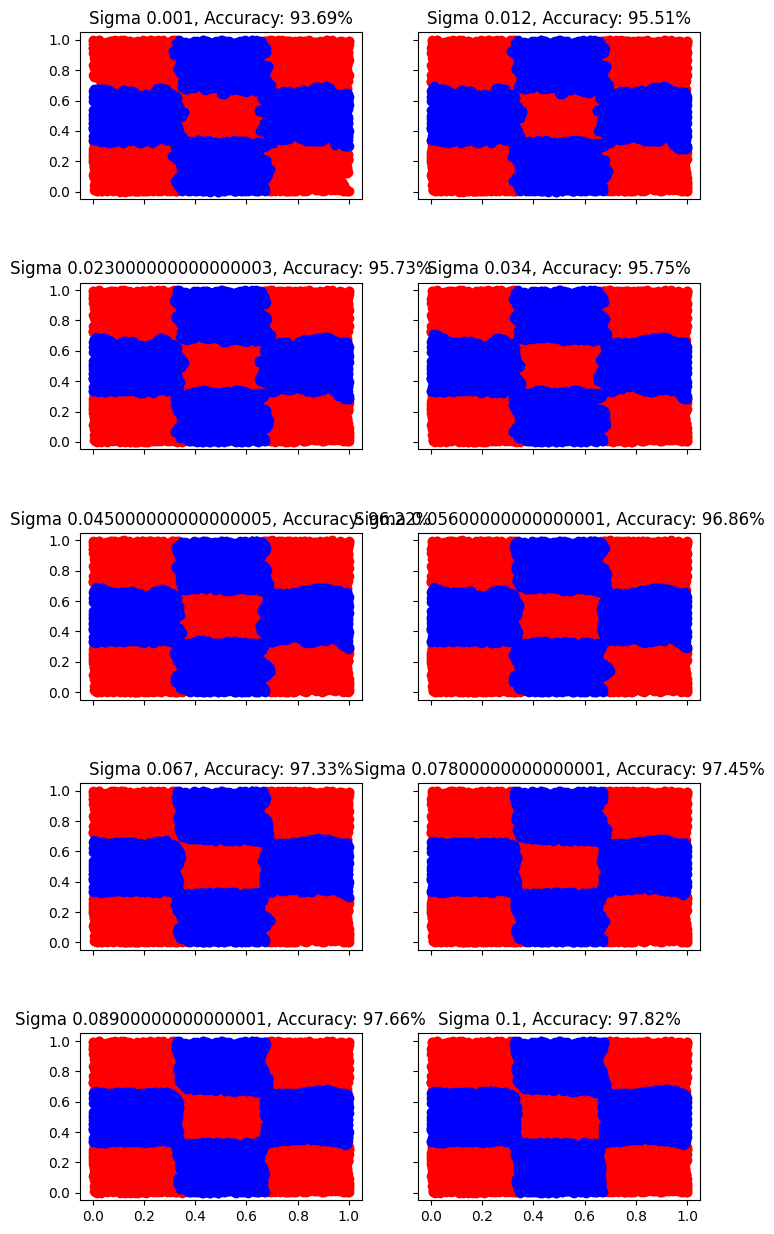

In [58]:
t_max=math.pow(10,)
eps=math.pow(10,-3)
min_sigma = math.pow(10,-3)
max_sigma = math.pow(10, -1)
sigmas_arr = np.linspace(min_sigma, max_sigma, 10)
performance = np.zeros(len(sigmas_arr))

fig, axes = plt.subplots(5, 2, figsize=(8, 16), sharex=True, sharey=True)
plt.subplots_adjust(bottom=0.15, hspace=0.5)
for index, sigma in enumerate(sigmas_arr):
    alphas = train_gaussian_kernel(sigma, X_train, y_train, eps, t_max)
    prediction = predict_gaussian_kernel(sigma, alphas, X_train, y_train, X_test)
    performance[index] = np.sum(prediction == y_test) / len(y_test)

    row = index // 2  # Row index
    col = index % 2   # Column index

    axes[row, col].scatter(X_test[0,prediction==-1.],X_test[1,prediction==-1.],c='r')
    axes[row, col].scatter(X_test[0,prediction==1.],X_test[1,prediction==1.],c='b')
    axes[row, col].set_title(f'Sigma {sigma:.3}, Accuracy: {performance[index]:.2%}')

    

array([ 0.01      ,  0.53578947,  1.06157895,  1.58736842,  2.11315789,
        2.63894737,  3.16473684,  3.69052632,  4.21631579,  4.74210526,
        5.26789474,  5.79368421,  6.31947368,  6.84526316,  7.37105263,
        7.89684211,  8.42263158,  8.94842105,  9.47421053, 10.        ])